Object.tar (SketchyCOCO dataset):


https://drive.google.com/file/d/1P2kb1SCqnZrK_P32Vmcf5FShjbC9kN7e/view?usp=drive_link

pretrained.zip (PhotoSketch model):


https://drive.google.com/file/d/1TQf-LyS8rRDDapdcTnEgWzYJllPgiXdj/view

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!tar -xvf /content/drive/MyDrive/Object.tar -C /content

In [3]:
import os
import shutil
from tqdm import tqdm

source_base = "/content/Object"
dest_base = "/content/SketchyCOCO"
categories = {'GT':'image', 'Sketch':'COCOSketch', 'Edge':'edge'}
subdirs = ['train', 'val']
selected_classes = {'24': 'zebra', '25': 'giraffe'}

for category in categories.values():
        for class_name in selected_classes.values():
            path = os.path.join(dest_base, category, class_name)
            os.makedirs(path, exist_ok=True)

def get_common_files(class_num):
    common_files = None

    for category in categories.keys():
        base_names = set()
        for subdir in subdirs:
            source_dir = os.path.join(source_base, category, subdir, class_num)
            if os.path.exists(source_dir):
                files = [os.path.splitext(f)[0].lower() for f in os.listdir(source_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('._')]
                base_names.update(files)

        if common_files is None:
            common_files = base_names
        else:
            common_files.intersection_update(base_names)

    return sorted(common_files)


for class_num, class_name in selected_classes.items():
    common_base_names = get_common_files(class_num)[:2000]

    if not common_base_names:
        continue

    for category in categories.keys():
        dest_dir = os.path.join(dest_base, categories[category], class_name)

        for base_name in tqdm(common_base_names, desc=f"Copying {class_name} {category}"):
            found = False
            for subdir in subdirs:
                source_dir = os.path.join(source_base, category, subdir, class_num)
                if not os.path.exists(source_dir):
                    continue
                for ext in ['.jpg', '.jpeg', '.png']:
                    file_path = os.path.join(source_dir, base_name + ext)
                    if os.path.exists(file_path):
                        shutil.copy2(file_path, os.path.join(dest_dir, base_name + ext))
                        found = True
                        break
                if found:
                    break

Copying giraffe Edge: 100%|██████████| 2000/2000 [00:01<00:00, 1585.78it/s]


In [13]:
%%capture
!git clone https://github.com/mtli/PhotoSketch.git

In [14]:
os.makedirs("/content/PhotoSketch/checkpoints/pretrained", exist_ok=True)

In [15]:
!unzip /content/drive/MyDrive/pretrained.zip -d /content/PhotoSketch/checkpoints/pretrained

Archive:  /content/drive/MyDrive/pretrained.zip
  inflating: /content/PhotoSketch/checkpoints/pretrained/latest_net_G.pth  
  inflating: /content/PhotoSketch/checkpoints/pretrained/latest_net_D.pth  
  inflating: /content/PhotoSketch/checkpoints/pretrained/LICENSE  


In [16]:
!cat /content/PhotoSketch/scripts/test_pretrained.sh

dataDir=

python test_pretrained.py \
    --name pretrained \
    --dataset_mode test_dir \
    --dataroot examples/ \
    --results_dir ${dataDir}/Exp/PhotoSketch/Results/ \
    --checkpoints_dir ${dataDir}/Exp/PhotoSketch/Checkpoints/ \
    --model pix2pix \
    --which_direction AtoB \
    --norm batch \
    --input_nc 3 \
    --output_nc 1 \
    --which_model_netG resnet_9blocks \
    --no_dropout \

In [ ]:
%%capture
!python PhotoSketch/test_pretrained.py \
    --name pretrained \
    --dataset_mode test_dir \
    --dataroot /content/SketchyCOCO/image/giraffe \
    --results_dir /content/SketchyCOCO/sketch/giraffe \
    --checkpoints_dir /content/PhotoSketch/checkpoints/ \
    --model pix2pix \
    --which_direction AtoB \
    --norm batch \
    --input_nc 3 \
    --output_nc 1 \
    --which_model_netG resnet_9blocks \
    --no_dropout

In [ ]:
%%capture
!python PhotoSketch/test_pretrained.py \
    --name pretrained \
    --dataset_mode test_dir \
    --dataroot /content/SketchyCOCO/image/zebra \
    --results_dir /content/SketchyCOCO/sketch/zebra \
    --checkpoints_dir /content/PhotoSketch/checkpoints/ \
    --model pix2pix \
    --which_direction AtoB \
    --norm batch \
    --input_nc 3 \
    --output_nc 1 \
    --which_model_netG resnet_9blocks \
    --no_dropout

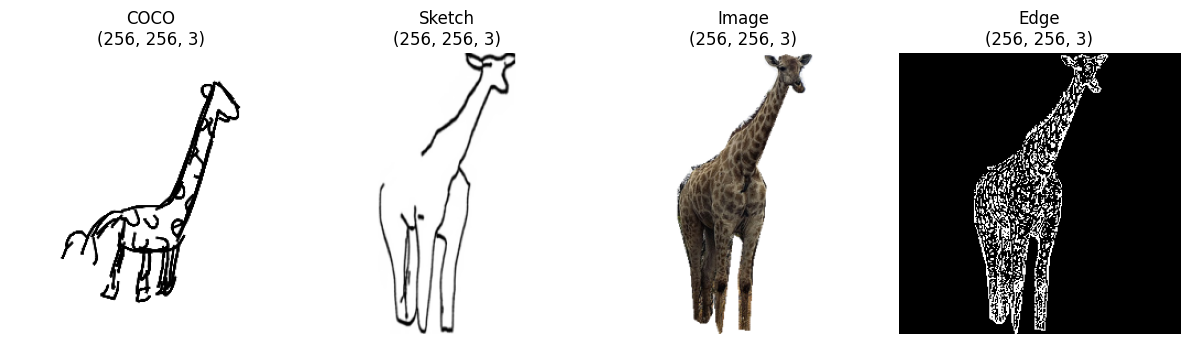

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_with_padding(image, target_size=256):
    h, w = image.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                borderType=cv2.BORDER_CONSTANT,
                                value=(255, 255, 255))
    return padded

coco_path = "/content/SketchyCOCO/COCOSketch/giraffe/1413600.png"
sketch_path = "/content/SketchyCOCO/sketch/giraffe/1413600.png"
image_path = "/content/SketchyCOCO/image/giraffe/1413600.png"
edge_path = "/content/SketchyCOCO/edge/giraffe/1413600.png"

coco = cv2.imread(coco_path)
sketch = cv2.imread(sketch_path)
image = cv2.imread(image_path)
edge = cv2.imread(edge_path)

coco_resized = resize_with_padding(coco)
sketch_resized = resize_with_padding(sketch)
image_resized = resize_with_padding(image)

edge_resized = resize_with_padding(edge)
edge_resized = np.clip(edge_resized.astype(np.float32) / 255.0, 0, 1)
edge_resized = (edge_resized * 255).astype(np.uint8)
_, edge_binary = cv2.threshold(edge_resized, 127, 255, cv2.THRESH_BINARY_INV)

def convert(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

titles = [
    f"COCO\n{coco_resized.shape}",
    f"Sketch\n{sketch_resized.shape}",
    f"Image\n{image_resized.shape}",
    f"Edge\n{edge_binary.shape}"
]
images = [convert(coco_resized), convert(sketch_resized), convert(image_resized), convert(edge_binary)]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [56]:
root = "/content/SketchyCOCO"
categories = ['giraffe', 'zebra']
out_root = "/content/COCO"

for category in categories:
    file_list = os.listdir(os.path.join(root, "sketch", category))
    for file_name in file_list:
        coco_path = os.path.join(root, "COCOSketch", category, file_name)
        sketch_path = os.path.join(root, "sketch", category, file_name)
        image_path = os.path.join(root, "image", category, file_name)
        edge_path = os.path.join(root, "edge", category, file_name)

        coco = cv2.imread(coco_path)
        sketch = cv2.imread(sketch_path)
        image = cv2.imread(image_path)
        edge = cv2.imread(edge_path)

        coco_resized = resize_with_padding(coco)
        sketch_resized = resize_with_padding(sketch)
        image_resized = resize_with_padding(image)
        edge_resized = resize_with_padding(edge)
        edge_resized = np.clip(edge_resized.astype(np.float32) / 255.0, 0, 1)
        edge_resized = (edge_resized * 255).astype(np.uint8)
        _, edge_binary = cv2.threshold(edge_resized, 127, 255, cv2.THRESH_BINARY_INV)

        save_paths = {
            "sketch": sketch_resized,
            "image": image_resized,
            "edge": edge_binary,
            "COCOSketch": coco_resized
        }

        for subfolder, img in save_paths.items():
            save_dir = os.path.join(out_root, subfolder, category)
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, file_name)
            cv2.imwrite(save_path, img)

In [62]:
source_root = "/content/COCO"
dest_root = "/content/COCO_50"

categories = ['giraffe', 'zebra']
types = ['COCOSketch', 'sketch', 'image', 'edge']
num_samples = 50

for t in types:
    for category in categories:
        src_dir = os.path.join(source_root, t, category)
        dst_dir = os.path.join(dest_root, t, category)
        os.makedirs(dst_dir, exist_ok=True)

        files = sorted(os.listdir(src_dir))
        selected_files = files[:num_samples]

        for f in selected_files:
            src_path = os.path.join(src_dir, f)
            dst_path = os.path.join(dst_dir, f)
            shutil.copy2(src_path, dst_path)

In [3]:
%cd /content
!mkdir zip
%cd zip
!wget https://www.7-zip.org/a/7z2301-linux-x64.tar.xz
!tar -xf 7z2301-linux-x64.tar.xz
%cd ..

/content
/content/zip
--2025-06-21 21:01:56--  https://www.7-zip.org/a/7z2301-linux-x64.tar.xz
Resolving www.7-zip.org (www.7-zip.org)... 49.12.202.237
Connecting to www.7-zip.org (www.7-zip.org)|49.12.202.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1527700 (1.5M) [application/octet-stream]
Saving to: ‘7z2301-linux-x64.tar.xz’

7z2301-linux-x64.ta 100%[===================>]   1.46M  2.39MB/s    in 0.6s    

2025-06-21 21:01:58 (2.39 MB/s) - ‘7z2301-linux-x64.tar.xz’ saved [1527700/1527700]

/content


In [64]:
!./zip/7zz a COCO.zip COCO/

!mv COCO.zip /content/drive/MyDrive/


7-Zip (z) 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20
 64-bit locale=en_US.UTF-8 Threads:2 OPEN_MAX:1048576, ASM

Scanning the drive:
  0M Scan           13 folders, 12000 files, 367088885 bytes (351 MiB)

Creating archive: COCO.zip

Add new data to archive: 13 folders, 12000 files, 367088885 bytes (351 MiB)

  0%      0% 162 + COCO/COCOSketch/giraffe/594688.png                                               1% 356 + COCO/COCOSketch/giraffe/595289.png                                               1% 543 + COCO/COCOSketch/giraffe/595816.png                                               2% 734 + COCO/COCOSketch/giraffe/596379.png   

In [63]:
!./zip/7zz a COCO_50.zip COCO_50/

!mv COCO_50.zip /content/drive/MyDrive/


7-Zip (z) 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20
 64-bit locale=en_US.UTF-8 Threads:2 OPEN_MAX:1048576, ASM

Scanning the drive:
  0M Scan           13 folders, 400 files, 12270515 bytes (12 MiB)

Creating archive: COCO_50.zip

Add new data to archive: 13 folders, 400 files, 12270515 bytes (12 MiB)

  0%     27% 218 + COCO_50/image/giraffe/1413840.png                                             67% 304 + COCO_50/sketch/giraffe/1413710.png                                             
Files read from disk: 400
Archive size: 10721675 bytes (11 MiB)
Everything is Ok


In [ ]:
!/content/zip/7zz x "/content/drive/MyDrive/COCO.zip" -o"/content" -y

In [ ]:
!/content/zip/7zz x "/content/drive/MyDrive/COCO_50.zip" -o"/content" -y